In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from myfunc.mysubplot import subplots

### Load source and destination images

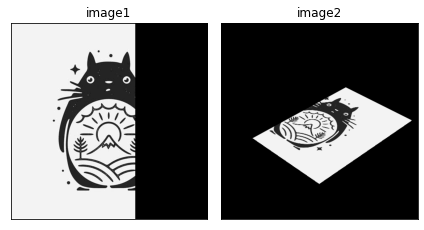

In [3]:
image1 = np.loadtxt('img_1.txt', delimiter=",").astype(np.uint8)
image2 = np.loadtxt('img_2.txt', delimiter=",").astype(np.uint8)

subplots([image1, image2], ['image1', 'image2'], 1, 2)

### SIFT

In [4]:
MIN_MATCH_COUNT = 10
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

### Matching with RANSAC 

True

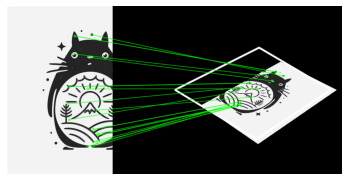

In [5]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = image1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
matches = cv.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.axis('off')
plt.imshow(matches, cmap='gray')

### Image stitching

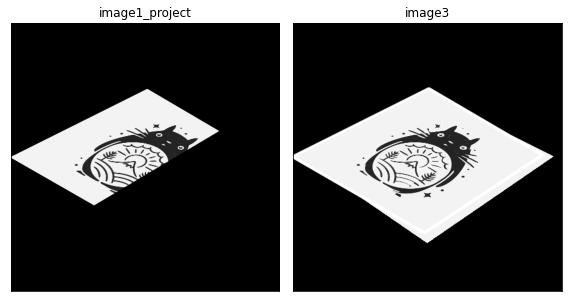

In [12]:
fig = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))
image1_proj = cv.warpPerspective(image1,M,(h,w))
image3 = np.maximum(image1_proj, image2)
subplots([image1_proj, image3], ['image1_project', 'image3'], 1, 2)

### Compute homography

In [ ]:
coords = corner_peaks(corner_harris(image1), min_distance=5, threshold_rel=0.5)
fig, ax = plt.subplots()
ax.imshow(image1, cmap=plt.cm.gray)
ax.plot([190, 204, 279, 167, 235, 288, 159, 281], [72, 98, 73, 277, 271, 317, 403, 403], color='red', marker='p',
        linestyle='None', markersize=3)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.set_axis_off()
plt.show()

In [6]:
matches1 = np.array([[190, 204, 279, 167, 235, 288, 159, 281], [72, 98, 73, 277, 271, 317, 403, 403]]).T
matches1.resize(8,2)

matches2 = np.array([[285, 282, 328, 185, 219, 221, 117, 175], [184, 193, 206, 228, 246, 273, 261, 298]]).T
matches2.resize(8,2) 
